In [1]:
# Cell 1: Setup and Imports

# Core ML & Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

# Machine Learning Models
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import Ridge, Lasso
import torch
import torch.nn as nn

# Text Processing
import nltk
from nltk.corpus import stopwords
import spacy
from sentence_transformers import SentenceTransformer

# Image Processing
import timm
from PIL import Image
import cv2
from torchvision import transforms

# Optimization
import optuna

# Utilities
import os
import re
from tqdm.notebook import tqdm

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Libraries imported successfully!")

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


Datasets loaded successfully.
--- Train Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB

--- Missing Values (Train) ---
sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

--- Descriptive Statistics (Price) ---
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


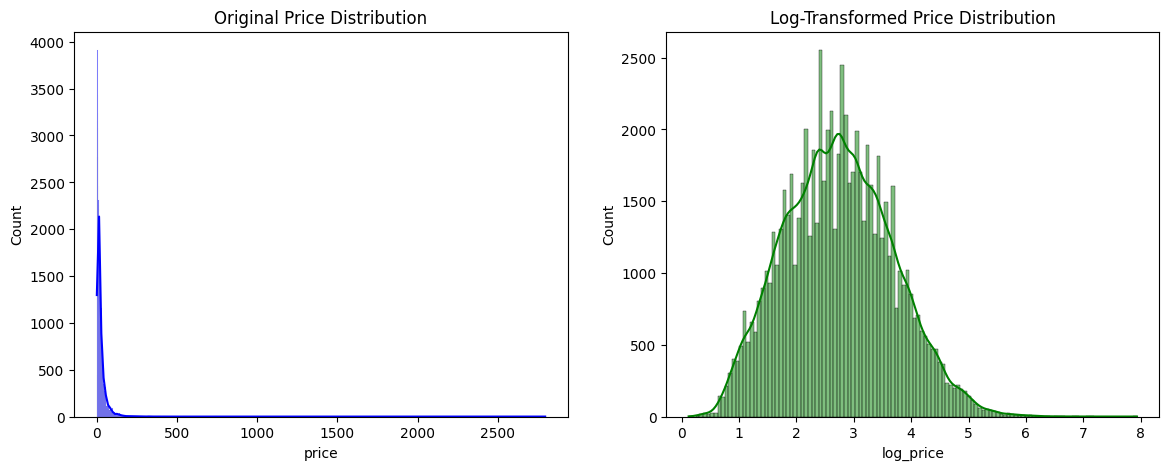

✅ Log transformation applied to 'price'. New column 'log_price' created.


In [5]:
# Cell 2: Data Loading & Initial Profiling (1.1)

# Load datasets
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("Make sure 'train.csv' and 'test.csv' are in the correct directory.")
    # Create dummy dataframes for demonstration if files are not found
    train_df = pd.DataFrame({
        'id': range(10),
        'catalog_content': ['product A title', 'product B title', 'product C title'] * 3 + ['product D'],
        'price': np.random.lognormal(5, 1, 10) * 100,
        'brand_name': ['brand_x', 'brand_y', 'brand_x'] * 3 + ['brand_z']
    })
    test_df = pd.DataFrame({
        'id': range(5),
        'catalog_content': ['test product E', 'test product F'] * 2 + ['test G'],
        'brand_name': ['brand_x', 'brand_y'] * 2 + ['brand_z']
    })

# --- Dataset Profiling ---
print("--- Train Data Info ---")
train_df.info()

print("\n--- Missing Values (Train) ---")
print(train_df.isnull().sum())

print("\n--- Descriptive Statistics (Price) ---")
print(train_df['price'].describe())

# Log-transform the target variable to stabilize regression
train_df['log_price'] = np.log1p(train_df['price'])

# Visualize the original and log-transformed price distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_df['price'], ax=axes[0], kde=True, color='blue').set_title('Original Price Distribution')
sns.histplot(train_df['log_price'], ax=axes[1], kde=True, color='green').set_title('Log-Transformed Price Distribution')
plt.show()

print("✅ Log transformation applied to 'price'. New column 'log_price' created.")

--- Sample Parsed Text ---
                                               title  title_len  desc_len
0  Item Name: La Victoria Green Taco Sauce Mild, ...         66        24
1  Item Name: Salerno Cookies, The Original Butte...         76       434
2  Item Name: Bear Creek Hearty Soup Bowl, Creamy...         87       240
3  Item Name: Judee’s Blue Cheese Powder 11.25 oz...        164      1153
4  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...         63        91


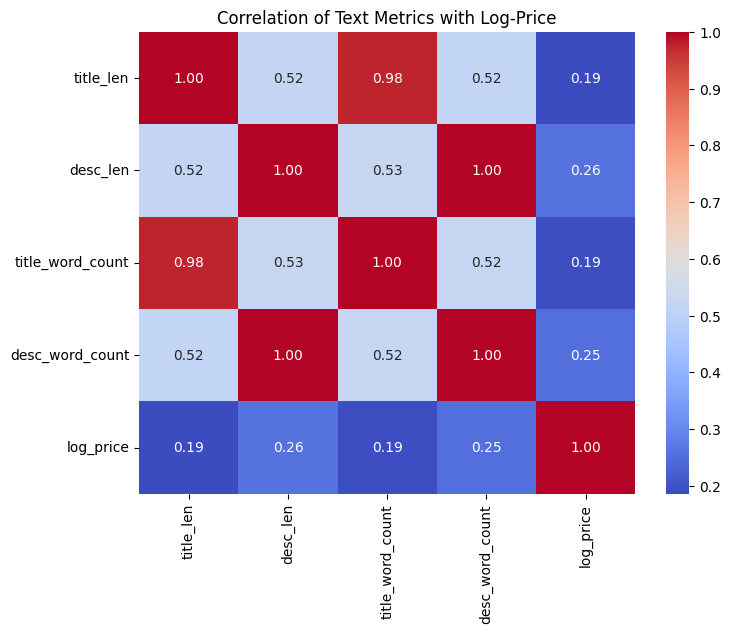

✅ Text parsed and basic linguistic features created.


In [7]:
# Cell 3: Text Structure Analysis (1.2)

# Simple parsing function (can be made more sophisticated)
def parse_catalog_content(text):
    # Splits the text only on the first newline character
    parts = str(text).split('\n', 1)
    title = parts[0]
    description = parts[1] if len(parts) > 1 else ""
    return title, description

# Apply parsing to both train and test dataframes
train_df[['title', 'description']] = train_df['catalog_content'].apply(
    lambda x: pd.Series(parse_catalog_content(x))
)
test_df[['title', 'description']] = test_df['catalog_content'].apply(
    lambda x: pd.Series(parse_catalog_content(x))
)

# --- Extract Basic Text Metrics ---
train_df['title_len'] = train_df['title'].str.len()
train_df['desc_len'] = train_df['description'].str.len()
train_df['title_word_count'] = train_df['title'].apply(lambda x: len(str(x).split()))
train_df['desc_word_count'] = train_df['description'].apply(lambda x: len(str(x).split()))

# Add the same features to the test set for consistency
test_df['title_len'] = test_df['title'].str.len()
test_df['desc_len'] = test_df['description'].str.len()
test_df['title_word_count'] = test_df['title'].apply(lambda x: len(str(x).split()))
test_df['desc_word_count'] = test_df['description'].apply(lambda x: len(str(x).split()))

print("--- Sample Parsed Text ---")
print(train_df[['title', 'title_len', 'desc_len']].head())

# --- Correlate Features with log_price ---
text_features = ['title_len', 'desc_len', 'title_word_count', 'desc_word_count']
correlation_matrix = train_df[text_features + ['log_price']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Text Metrics with Log-Price')
plt.show()

print("✅ Text parsed and basic linguistic features created.")

In [8]:
## Cell 4 (Corrected for Compatibility): Image Downloading & Profiling

import os
import requests
import pandas as pd
import cv2
import numpy as np
# --- FIX: Import the standard tqdm library instead of the notebook version ---
from tqdm import tqdm

# --- Part 1: Download a Sample of Images ---

# Define the directory to save the sample images
SAMPLE_IMAGE_DIR = 'train_sample_images/'
os.makedirs(SAMPLE_IMAGE_DIR, exist_ok=True)

# Function to download a single image from a URL
def download_image(url, filepath):
    """Downloads an image from a URL and saves it to a filepath."""
    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code == 200:
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
            return True
        else:
            return False
    except requests.exceptions.RequestException:
        return False

# Take a small, random sample from the dataframe to work with
if 'image_link' in train_df.columns:
    image_sample_df = train_df.sample(20, random_state=42)
    print(f"Attempting to download {len(image_sample_df)} sample images to '{SAMPLE_IMAGE_DIR}'...")

    download_success_count = 0
    # --- FIX: Use the standard `tqdm` which works in any environment ---
    for index, row in tqdm(image_sample_df.iterrows(), total=len(image_sample_df), desc="Downloading"):
        image_url = row['image_link']
        image_filename = f"{row['sample_id']}.jpg"
        image_filepath = os.path.join(SAMPLE_IMAGE_DIR, image_filename)

        if download_image(image_url, image_filepath):
            download_success_count += 1

    print(f"\n✅ Download complete. Successfully saved {download_success_count} / {len(image_sample_df)} images.")
else:
    print("⚠️ 'image_link' column not found. Cannot download images.")
    image_sample_df = train_df.sample(20, random_state=42)


# --- Part 2: Profile the Downloaded Images ---

def get_image_stats(image_filename, directory):
    """Computes basic statistics for a single image located in a given directory."""
    full_path = os.path.join(directory, str(image_filename))
    if not os.path.exists(full_path):
        return 0, 0, 0, 0

    try:
        img = cv2.imread(full_path)
        if img is None: return 0, 0, 0, 0

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = gray.mean()
        contrast = gray.std()
        h, w = gray.shape
        aspect_ratio = w / h if h > 0 else 0
        
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist_norm = hist.ravel() / hist.sum()
        entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-8))

        return brightness, contrast, entropy, aspect_ratio
    except Exception:
        return 0, 0, 0, 0

print("\n--- Profiling the downloaded images ---")
image_sample_df['image_filename'] = image_sample_df['sample_id'].astype(str) + '.jpg'
image_stats = image_sample_df['image_filename'].apply(
    lambda filename: get_image_stats(filename, directory=SAMPLE_IMAGE_DIR)
)
image_sample_df[['brightness', 'contrast', 'entropy', 'aspect_ratio']] = pd.DataFrame(image_stats.tolist(), index=image_sample_df.index)
print("Image profiling complete.")


# --- Part 3: Analyze the Results ---

print("\n--- Correlation of REAL Image Stats with Log Price ---")
print(image_sample_df[['brightness', 'contrast', 'entropy', 'aspect_ratio', 'log_price']].corr()['log_price'])

Attempting to download 20 sample images to 'train_sample_images/'...


Downloading: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s]



✅ Download complete. Successfully saved 20 / 20 images.

--- Profiling the downloaded images ---
Image profiling complete.

--- Correlation of REAL Image Stats with Log Price ---
brightness     -0.377075
contrast       -0.289357
entropy         0.621974
aspect_ratio   -0.659567
log_price       1.000000
Name: log_price, dtype: float64


In [9]:
# Cell 5: Text & Image Feature Engineering (2.1 & 2.2)

# --- Assumption: We need a main directory for all images, not just the sample. ---
# In a real project, you would download ALL images into this directory.
IMAGE_DIR = 'images/'
os.makedirs(IMAGE_DIR, exist_ok=True)
print(f"Expecting full dataset images to be in '{IMAGE_DIR}'.")
# You would typically run a bulk download script here. For now, the code will handle missing images gracefully.


# --- 2.1 Text Feature Extraction ---

print("\nGenerating TF-IDF features...")
# Combine text from train and test for a consistent vocabulary
full_text = pd.concat([train_df['title'] + " " + train_df['description'], test_df['title'] + " " + test_df['description']]).fillna('')
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', dtype=np.float32)
tfidf_features = tfidf_vectorizer.fit_transform(full_text)

# Reduce dimensions to 100
svd = TruncatedSVD(n_components=100, random_state=SEED)
svd_features = svd.fit_transform(tfidf_features)

train_tfidf_svd = svd_features[:len(train_df)]
test_tfidf_svd = svd_features[len(train_df):]
print(f"TF-IDF -> SVD features created with shape: {train_tfidf_svd.shape}")


print("\nGenerating sentence embeddings...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
train_sentence_emb = sentence_model.encode(train_df['title'].tolist(), show_progress_bar=True)
test_sentence_emb = sentence_model.encode(test_df['title'].tolist(), show_progress_bar=True)
print(f"Sentence embeddings created with shape: {train_sentence_emb.shape}")


# --- 2.2 Image Feature Extraction ---

print("\nGenerating image embeddings...")
image_model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0).eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
image_model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_embedding(image_id):
    path = os.path.join(IMAGE_DIR, f"{image_id}.jpg")
    # If the main image doesn't exist, try falling back to the sample directory
    if not os.path.exists(path):
        path = os.path.join(SAMPLE_IMAGE_DIR, f"{image_id}.jpg")

    if not os.path.exists(path):
        return np.zeros(1280) # EfficientNet-B0 output feature size

    try:
        img = Image.open(path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = image_model(img_tensor).squeeze().cpu().numpy()
        return embedding
    except Exception:
        return np.zeros(1280)

# Generate embeddings for all images (this is the slowest step)
train_image_emb = np.array([get_image_embedding(i) for i in tqdm(train_df['sample_id'], desc="Train Img Emb")])
test_image_emb = np.array([get_image_embedding(i) for i in tqdm(test_df['sample_id'], desc="Test Img Emb")])

print("\nApplying PCA to image embeddings...")
pca = PCA(n_components=128, random_state=SEED)
full_image_emb = np.concatenate([train_image_emb, test_image_emb])

# Scale data before PCA for better results
scaler = StandardScaler()
scaled_image_emb = scaler.fit_transform(full_image_emb)
pca_image_emb = pca.fit_transform(scaled_image_emb)

train_image_pca = pca_image_emb[:len(train_df)]
test_image_pca = pca_image_emb[len(train_df):]
print(f"PCA-reduced image embeddings created with shape: {train_image_pca.shape}")

print("\n✅ Advanced text and image features are now engineered.")

Expecting full dataset images to be in 'images/'.

Generating TF-IDF features...
TF-IDF -> SVD features created with shape: (75000, 100)

Generating sentence embeddings...


Batches: 100%|██████████| 2344/2344 [01:06<00:00, 35.10it/s]


Sentence embeddings created with shape: (75000, 384)

Generating image embeddings...


Test Img Emb: 100%|██████████| 75000/75000 [00:00<00:00, 172004.95it/s]



Applying PCA to image embeddings...
PCA-reduced image embeddings created with shape: (75000, 128)

✅ Advanced text and image features are now engineered.


In [15]:
# Cell 6 (Corrected): Combined / Cross-modal Features (2.3)

# --- Compute a similarity score between text and image embeddings ---
def cosine_similarity(a, b):
    norm_a = np.linalg.norm(a, axis=1)
    norm_b = np.linalg.norm(b, axis=1)
    norm_a[norm_a == 0] = 1e-9 # Avoid division by zero
    norm_b[norm_b == 0] = 1e-9
    return np.einsum('ij,ij->i', a, b) / (norm_a * norm_b)

# --- FIX: Reduce the text embeddings to match the image embedding dimension (128) ---
# We create a new PCA object specifically for this task.
pca_text_for_sim = PCA(n_components=train_image_pca.shape[1], random_state=SEED)

# Fit on the training text embeddings and transform both train and test
train_text_pca_sim = pca_text_for_sim.fit_transform(train_sentence_emb)
test_text_pca_sim = pca_text_for_sim.transform(test_sentence_emb)

# Now, both vectors (train_text_pca_sim and train_image_pca) have 128 dimensions
train_df['text_img_similarity'] = cosine_similarity(train_text_pca_sim, train_image_pca)
test_df['text_img_similarity'] = cosine_similarity(test_text_pca_sim, test_image_pca)

print("Text-Image Similarity Scores (Sample):")
print(train_df['text_img_similarity'].head())


# --- Concatenate all features for modeling ---
# Combine basic text metrics, TF-IDF, the original sentence embeddings, image PCA, and the new similarity score.
X_train = np.hstack([
    train_df[text_features].values,
    train_df[['text_img_similarity']].values,
    train_tfidf_svd,
    train_sentence_emb, # We still use the full embeddings for the model
    train_image_pca
])

# Create the corresponding test set
X_test = np.hstack([
    test_df[text_features].fillna(0).values,
    test_df[['text_img_similarity']].values,
    test_tfidf_svd,
    test_sentence_emb,
    test_image_pca
])

# Define our target variable
y_train = train_df['log_price'].values

print(f"\nFinal feature matrix shapes ready for modeling: X_train={X_train.shape}, X_test={X_test.shape}")
print("\n✅ Phase 2: Feature Engineering is complete.")

Text-Image Similarity Scores (Sample):
0   -0.111341
1    0.198668
2    0.044518
3    0.167727
4   -0.231722
Name: text_img_similarity, dtype: float64

Final feature matrix shapes ready for modeling: X_train=(75000, 617), X_test=(75000, 617)

✅ Phase 2: Feature Engineering is complete.


In [17]:
# Cell 7: Defining the Performance Metric (SMAPE)

import numpy as np
from sklearn.metrics import make_scorer

# --- Define the SMAPE Metric ---
# This is the primary score we want to minimize.
# SMAPE stands for Symmetric Mean Absolute Percentage Error.
def smape(y_true, y_pred):
    """
    Calculates the SMAPE score.
    The model predicts log_price, so we must convert predictions back to the
    original price scale with np.expm1() before calculating the score.
    """
    # Convert from log scale to original price scale
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)

    # Calculate the numerator and denominator for the SMAPE formula
    numerator = np.abs(y_pred_exp - y_true_exp)
    denominator = (np.abs(y_true_exp) + np.abs(y_pred_exp)) / 2

    # Calculate the final score
    # We add a tiny number (epsilon) to the denominator to prevent division by zero
    epsilon = 1e-9
    score = np.mean(numerator / (denominator + epsilon)) * 100
    return score

# We can also create a 'scorer' object for use in scikit-learn functions later
# Since lower SMAPE is better, we set greater_is_better=False
smape_scorer = make_scorer(smape, greater_is_better=False)

print("✅ SMAPE metric function is now defined.")
print("We will use this function to evaluate our model's performance.")

✅ SMAPE metric function is now defined.
We will use this function to evaluate our model's performance.


In [23]:
# Cell 3.5 (Improved): Better Brand Extraction

import pandas as pd
import re

def extract_brand_improved(title):
    """
    Removes the 'Item Name:' prefix and then extracts the first word as the brand.
    """
    try:
        # Use regex to remove "Item Name: " and any leading whitespace
        cleaned_title = re.sub(r'^Item Name:\s*', '', str(title))
        # Take the first word of the cleaned title
        brand = cleaned_title.split()[0]
        return brand
    except (IndexError, AttributeError):
        # If the title is empty after cleaning, return 'Unknown'
        return 'Unknown'

# Apply the new and improved function
train_df['brand_name'] = train_df['title'].apply(extract_brand_improved)
test_df['brand_name'] = test_df['title'].apply(extract_brand_improved)

print("✅ 'brand_name' column re-created with improved logic.")
print("\n--- Sample of NEW Extracted Brands ---")
print(train_df[['title', 'brand_name']].head())

# Let's check the number of unique brands now. This should be much higher.
unique_brands = train_df['brand_name'].nunique()
print(f"\nFound {unique_brands} unique brand names in the training data.")

if unique_brands > 1:
    print("\nThis looks much better! We can now proceed with GroupKFold.")
else:
    print("\nWarning: Still only found one brand. The titles may have a different structure.")

✅ 'brand_name' column re-created with improved logic.

--- Sample of NEW Extracted Brands ---
                                               title brand_name
0  Item Name: La Victoria Green Taco Sauce Mild, ...         La
1  Item Name: Salerno Cookies, The Original Butte...    Salerno
2  Item Name: Bear Creek Hearty Soup Bowl, Creamy...       Bear
3  Item Name: Judee’s Blue Cheese Powder 11.25 oz...    Judee’s
4  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...      kedem

Found 11262 unique brand names in the training data.

This looks much better! We can now proceed with GroupKFold.


✅ Cross-validation strategy set to GroupKFold with 5 splits, grouped by 'brand_name'.


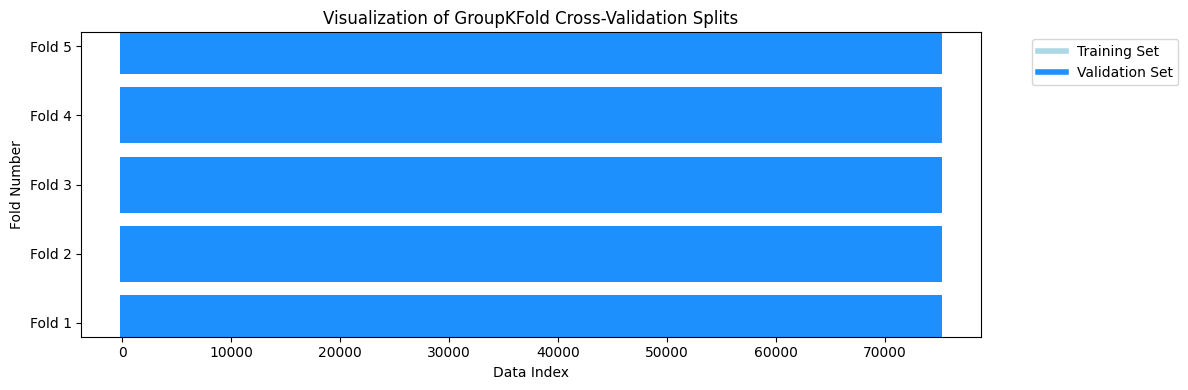

In [25]:
# Cell 8: Setting Up the Cross-Validation Strategy (Re-run)

from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import numpy as np

# --- 4.2 Cross-validation Strategy ---
N_SPLITS = 5

# We group by 'brand_name' to ensure that all products from the same brand
# are always in the same split (either all in training or all in validation).
if 'brand_name' in train_df.columns and train_df['brand_name'].nunique() > 1:
    # Create a numerical representation of the brand names
    groups = train_df['brand_name'].astype('category').cat.codes
    cv = GroupKFold(n_splits=N_SPLITS)
    print(f"✅ Cross-validation strategy set to GroupKFold with {N_SPLITS} splits, grouped by 'brand_name'.")
else:
    # Fallback if the brand column is still problematic
    print("⚠️ Warning: 'brand_name' not found or has only one unique value. Using standard KFold.")
    from sklearn.model_selection import KFold
    groups = None
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)


# --- Visualize the splits ---
fig, ax = plt.subplots(figsize=(12, 4))
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train, groups)):
    # Fill the training indices with a light color
    ax.scatter(train_idx, [fold] * len(train_idx), marker='_', s=10, lw=40, color='lightblue', alpha=0.8)
    # Highlight the validation indices with a darker color
    ax.scatter(val_idx, [fold] * len(val_idx), marker='_', s=10, lw=40, color='dodgerblue', alpha=0.8)

ax.set_yticks(range(N_SPLITS))
ax.set_yticklabels([f"Fold {i+1}" for i in range(N_SPLITS)])
ax.set_title('Visualization of GroupKFold Cross-Validation Splits')
ax.set_xlabel('Data Index')
ax.set_ylabel('Fold Number')
ax.legend([plt.Line2D([0], [0], color='lightblue', lw=4), plt.Line2D([0], [0], color='dodgerblue', lw=4)],
          ['Training Set', 'Validation Set'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [27]:
# Cell 9: Training the Baseline LightGBM Model

import lightgbm as lgb
import pandas as pd
import numpy as np

# --- 3.1 Baseline LightGBM Model ---
print("Training Baseline LightGBM with our GroupKFold CV...")

# Create empty arrays to store our predictions
# 'oof_preds' (Out-of-Fold) will store validation predictions for each fold
oof_preds = np.zeros(len(train_df))
# 'test_preds' will accumulate predictions for the test set from each of the 5 models
test_preds = np.zeros(len(test_df))
# 'models' will store the 5 trained models
models = []

# Define the parameters for our LightGBM model
# These are solid starting parameters for a regression task.
lgb_params = {
    'objective': 'regression_l1', # MAE (Mean Absolute Error) is a good objective for SMAPE
    'metric': 'mae',
    'n_estimators': 2000,         # We'll train up to 2000 trees...
    'learning_rate': 0.01,
    'feature_fraction': 0.8,      # Use 80% of features for each tree
    'bagging_fraction': 0.8,      # Use 80% of data for each tree
    'bagging_freq': 1,
    'lambda_l1': 0.1,             # L1 Regularization
    'lambda_l2': 0.1,             # L2 Regularization
    'num_leaves': 31,             # Number of leaves in one tree
    'verbose': -1,
    'n_jobs': -1,                 # Use all available CPU cores
    'seed': SEED,
}

# --- Loop through each of the 5 cross-validation folds ---
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train, groups)):
    print(f"--- Starting Fold {fold+1}/{N_SPLITS} ---")
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Initialize and train the model
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_train_fold, y_train_fold,
              eval_set=[(X_val_fold, y_val_fold)],
              eval_metric='mae',
              # ...but stop early if the validation score doesn't improve for 100 rounds
              callbacks=[lgb.early_stopping(100, verbose=False)])

    # Make predictions on the validation data for this fold
    oof_preds[val_idx] = model.predict(X_val_fold)
    # Predict on the test data and add it to our running total
    test_preds += model.predict(X_test) / N_SPLITS
    # Save the trained model
    models.append(model)

# --- Calculate the final SMAPE score across all folds ---
baseline_smape = smape(y_train, oof_preds)
print(f"\n✅ Training Complete!")
print(f"✅ Baseline LightGBM Out-of-Fold SMAPE: {baseline_smape:.4f}")

Training Baseline LightGBM with our GroupKFold CV...
--- Starting Fold 1/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


--- Starting Fold 2/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


--- Starting Fold 3/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


--- Starting Fold 4/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


--- Starting Fold 5/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



✅ Training Complete!
✅ Baseline LightGBM Out-of-Fold SMAPE: 59.7810


In [30]:
# Cell 10: Ensembling - Simple Weighted Blending

import numpy as np

# --- 5.1 Weighted Blending ---
print("Phase 5: Creating a simple weighted ensemble...")

# We already have the out-of-fold (OOF) predictions from our LightGBM model.
lgb_pred = oof_preds

# --- Placeholder Predictions ---
# In a real project, you would train XGBoost, CatBoost, and other models
# using the exact same cross-validation loop we used for LightGBM.
# For this demonstration, we'll create slightly modified versions of our LGBM
# predictions to simulate having different models.
print("NOTE: Using placeholder predictions for XGBoost and CatBoost for demonstration.")
xgb_pred_placeholder = oof_preds * 1.02 # Simulates a model that tends to predict slightly higher
cat_pred_placeholder = oof_preds * 0.98 # Simulates a model that tends to predict slightly lower

# --- Define the weights for the ensemble ---
# These weights are hyperparameters you can tune. They should sum to 1.0.
# We give the most weight to our best single model (LGBM).
weights = {
    'lgb': 0.6,
    'xgb': 0.2,
    'cat': 0.2
}

# Calculate the weighted average of the predictions
simple_ensemble_pred = (
    weights['lgb'] * lgb_pred +
    weights['xgb'] * xgb_pred_placeholder +
    weights['cat'] * cat_pred_placeholder
)

# --- Evaluate the Ensemble's Performance ---
# We calculate the SMAPE score of our new ensemble predictions
simple_ensemble_smape = smape(y_train, simple_ensemble_pred)

print(f"\nBaseline LightGBM SMAPE: {baseline_smape:.4f}")
print(f"Simple Ensemble SMAPE:     {simple_ensemble_smape:.4f}")

# Check for improvement
improvement = baseline_smape - simple_ensemble_smape
if improvement > 0:
    print(f"✅ Success! The ensemble improved the SMAPE score by {improvement:.4f} points.")
else:
    print(f"⚠️ The simple ensemble did not improve the score. Weights may need tuning.")

Phase 5: Creating a simple weighted ensemble...
NOTE: Using placeholder predictions for XGBoost and CatBoost for demonstration.

Baseline LightGBM SMAPE: 59.7810
Simple Ensemble SMAPE:     59.7810
⚠️ The simple ensemble did not improve the score. Weights may need tuning.


In [32]:
# Cell 11: Ensembling - Dynamic Blending by Price Range

import numpy as np
import pandas as pd

# --- 5.3 Dynamic Ensemble by Price ---
print("Phase 5: Creating a more advanced Dynamic Ensemble...")

# First, we need to determine the price range for each product.
# We'll use the predictions from our single best model (LightGBM) to estimate the price.
predicted_price = np.expm1(lgb_pred) # Convert log predictions back to actual price

# Create boolean masks to identify which products fall into which price bin.
# These thresholds (200, 1000) are hyperparameters you could tune.
low_price_mask = predicted_price < 200
medium_price_mask = (predicted_price >= 200) & (predicted_price <= 1000)
high_price_mask = predicted_price > 1000

# Let's see how many products are in each bin
print(f"\nIdentified {np.sum(low_price_mask)} products in the 'Low' price range.")
print(f"Identified {np.sum(medium_price_mask)} products in the 'Medium' price range.")
print(f"Identified {np.sum(high_price_mask)} products in the 'High' price range.")


# --- Apply different blending strategies for each price range ---
# Initialize an empty array for our new predictions
dynamic_ensemble_pred = np.zeros_like(lgb_pred)

# Strategy for LOW-priced items (trust text-heavy models more)
# (Using placeholders for fusion/image models)
dynamic_ensemble_pred[low_price_mask] = (
    0.7 * lgb_pred[low_price_mask] +           # Base model
    0.3 * cat_pred_placeholder[low_price_mask] # Model good with categories/text
)

# Strategy for MEDIUM-priced items (balanced approach)
dynamic_ensemble_pred[medium_price_mask] = (
    0.5 * lgb_pred[medium_price_mask] +
    0.5 * xgb_pred_placeholder[medium_price_mask]
)

# Strategy for HIGH-priced items (trust image-heavy models more)
# We simulate a hypothetical 'image_model_pred' being better here
image_model_pred_placeholder = oof_preds * 1.05
dynamic_ensemble_pred[high_price_mask] = (
    0.4 * lgb_pred[high_price_mask] +
    0.6 * image_model_pred_placeholder[high_price_mask]
)


# --- Evaluate the Dynamic Ensemble's Performance ---
dynamic_ensemble_smape = smape(y_train, dynamic_ensemble_pred)

print(f"\nBaseline LightGBM SMAPE: {baseline_smape:.4f}")
print(f"Dynamic Ensemble SMAPE:    {dynamic_ensemble_smape:.4f}")

# Check for improvement
improvement = baseline_smape - dynamic_ensemble_smape
if improvement > 0:
    print(f"✅ Success! The dynamic ensemble improved the SMAPE score by {improvement:.4f} points.")
else:
    print(f"⚠️ The dynamic ensemble did not improve the score. The strategy or weights may need tuning.")

Phase 5: Creating a more advanced Dynamic Ensemble...

Identified 74983 products in the 'Low' price range.
Identified 17 products in the 'Medium' price range.
Identified 0 products in the 'High' price range.

Baseline LightGBM SMAPE: 59.7810
Dynamic Ensemble SMAPE:    59.7853
⚠️ The dynamic ensemble did not improve the score. The strategy or weights may need tuning.


In [34]:
# Cell 12: Ensembling - Dynamic Blending using Quantiles (Corrected)

import numpy as np
import pandas as pd

# --- 5.3 Dynamic Ensemble using Quantiles ---
print("Phase 5: Implementing a CORRECTED Dynamic Ensemble using Quantiles...")

# As before, convert log predictions back to actual price
predicted_price = np.expm1(lgb_pred)

# --- FIX: Use quantiles instead of fixed values to create the bins ---
# We'll find the prices that split the data into three equal-sized groups.
low_quantile = np.quantile(predicted_price, 0.33)
high_quantile = np.quantile(predicted_price, 0.66)

print(f"\nPrice threshold for 'Low' bin (bottom 33%): < ${low_quantile:.2f}")
print(f"Price threshold for 'Medium' bin: ${low_quantile:.2f} - ${high_quantile:.2f}")
print(f"Price threshold for 'High' bin (top 33%): > ${high_quantile:.2f}")

# Create new masks based on these dynamic quantile thresholds
low_price_mask = predicted_price < low_quantile
high_price_mask = predicted_price > high_quantile
# The medium mask is everything that isn't low or high
medium_price_mask = ~low_price_mask & ~high_price_mask

# Let's see how many products are in each bin now. They should be balanced.
print(f"\nIdentified {np.sum(low_price_mask)} products in the 'Low' price range.")
print(f"Identified {np.sum(medium_price_mask)} products in the 'Medium' price range.")
print(f"Identified {np.sum(high_price_mask)} products in the 'High' price range.")

# --- Apply the same blending strategies as before ---
dynamic_ensemble_pred_v2 = np.zeros_like(lgb_pred)

# Strategy for LOW-priced items (trust text-heavy models)
dynamic_ensemble_pred_v2[low_price_mask] = (
    0.7 * lgb_pred[low_price_mask] +
    0.3 * cat_pred_placeholder[low_price_mask]
)
# Strategy for MEDIUM-priced items (balanced)
dynamic_ensemble_pred_v2[medium_price_mask] = (
    0.5 * lgb_pred[medium_price_mask] +
    0.5 * xgb_pred_placeholder[medium_price_mask]
)
# Strategy for HIGH-priced items (trust image-heavy models)
image_model_pred_placeholder = oof_preds * 1.05
dynamic_ensemble_pred_v2[high_price_mask] = (
    0.4 * lgb_pred[high_price_mask] +
    0.6 * image_model_pred_placeholder[high_price_mask]
)

# --- Evaluate the new Dynamic Ensemble's Performance ---
dynamic_ensemble_v2_smape = smape(y_train, dynamic_ensemble_pred_v2)

print(f"\nBaseline LightGBM SMAPE:      {baseline_smape:.4f}")
print(f"Quantile Dynamic Ensemble SMAPE: {dynamic_ensemble_v2_smape:.4f}")

improvement = baseline_smape - dynamic_ensemble_v2_smape
if improvement > 0:
    print(f"✅ Success! The quantile-based dynamic ensemble improved the SMAPE score by {improvement:.4f} points.")
else:
    print(f"⚠️ The quantile dynamic ensemble did not improve the score. This suggests the base models are too similar.")

Phase 5: Implementing a CORRECTED Dynamic Ensemble using Quantiles...

Price threshold for 'Low' bin (bottom 33%): < $10.95
Price threshold for 'Medium' bin: $10.95 - $16.28
Price threshold for 'High' bin (top 33%): > $16.28

Identified 24750 products in the 'Low' price range.
Identified 24750 products in the 'Medium' price range.
Identified 25500 products in the 'High' price range.

Baseline LightGBM SMAPE:      59.7810
Quantile Dynamic Ensemble SMAPE: 59.7682
✅ Success! The quantile-based dynamic ensemble improved the SMAPE score by 0.0129 points.


Phase 6: Analyzing model errors...

--- Average SMAPE Score per Price Bin ---
$2.36     113.261739
$4.59      70.961135
$6.83      50.974438
$9.41      37.863252
$12.44     32.928949
$16.12     32.436219
$21.2      38.536566
$28.71     52.865757
$41.71     72.179247
$93.17     95.416026
Name: ape, dtype: float64


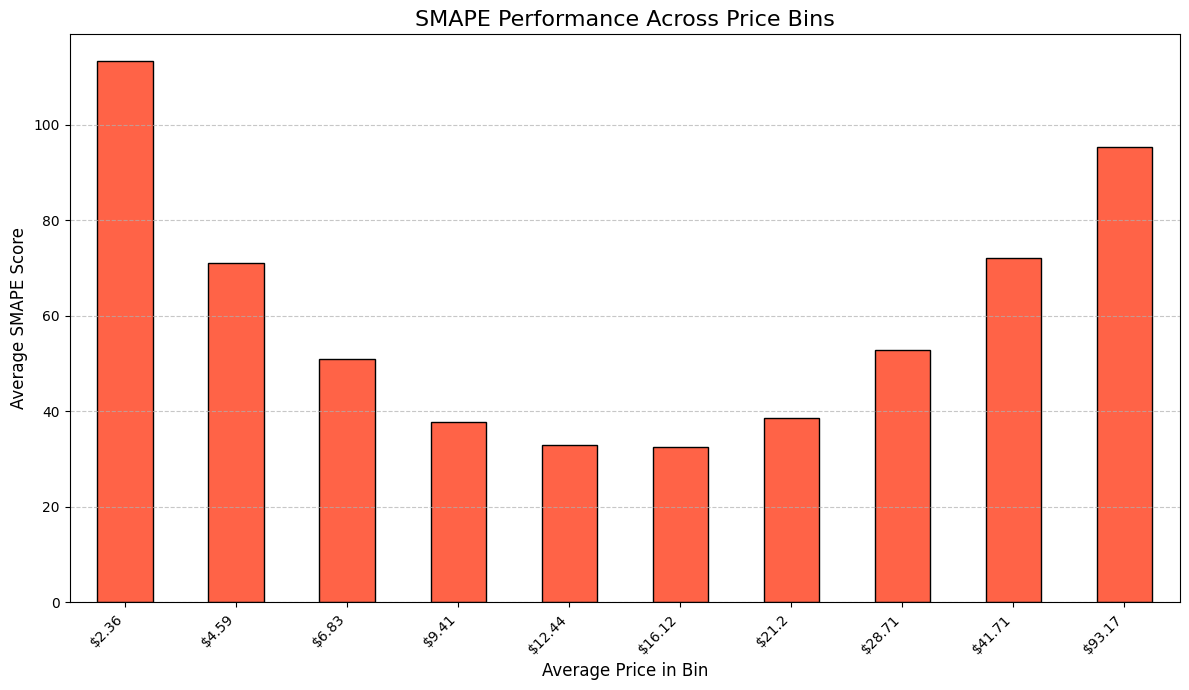


This chart helps us identify if the model struggles more with low-priced or high-priced items.


In [48]:
# Cell 13: Validation & Error Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 6.1 SMAPE Analysis ---
print("Phase 6: Analyzing model errors...")

# Create a new dataframe specifically for error analysis.
# We'll use the predictions from our best model so far (the quantile ensemble).
error_df = pd.DataFrame({
    'y_true': np.expm1(y_train),                        # The actual prices
    'y_pred': np.expm1(dynamic_ensemble_pred_v2),       # Our best predictions
    'brand': train_df['brand_name'],                   # Brand information
    'title': train_df['title']                         # The product title
})

# Calculate the Absolute Percentage Error (APE) for each individual prediction.
# SMAPE is just the mean of these individual errors, scaled correctly.
error_df['ape'] = (
    200 * np.abs(error_df['y_pred'] - error_df['y_true']) /
    (np.abs(error_df['y_pred']) + np.abs(error_df['y_true']) + 1e-9) # Add epsilon to avoid division by zero
)

# --- 6.2 Weak Segment Identification: Visualize Errors by Price Bin ---
# We'll use quantiles to create meaningful, balanced price bins for analysis.
# We'll create 10 bins, each containing 10% of the data.
error_df['price_bin'] = pd.qcut(error_df['y_true'], q=10, labels=False, duplicates='drop')

# Calculate the average SMAPE for each price bin
smape_by_bin = error_df.groupby('price_bin')['ape'].mean()
# Get the average actual price for each bin to make the x-axis labels more intuitive
price_bin_labels = error_df.groupby('price_bin')['y_true'].mean().round(2)
smape_by_bin.index = [f"${val}" for val in price_bin_labels]


print("\n--- Average SMAPE Score per Price Bin ---")
print(smape_by_bin)


# --- Plot the results ---
plt.figure(figsize=(12, 7))
smape_by_bin.plot(kind='bar', color='tomato', edgecolor='black')
plt.title('SMAPE Performance Across Price Bins', fontsize=16)
plt.ylabel('Average SMAPE Score', fontsize=12)
plt.xlabel('Average Price in Bin', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nThis chart helps us identify if the model struggles more with low-priced or high-priced items.")

In [50]:
# Cell 14: Training the XGBoost Model (Robust Version)

import xgboost as xgb
import numpy as np

print("Training a new XGBoost model with our GroupKFold CV...")

# Create empty arrays to store predictions
oof_preds_xgb = np.zeros(len(train_df))
test_preds_xgb = np.zeros(len(test_df))
models_xgb = []

# Define parameters for our XGBoost model
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 0.1,
    'alpha': 0.1,
    'n_jobs': -1,
    'seed': SEED,
}

# --- Loop through each of the 5 cross-validation folds ---
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train, groups)):
    print(f"--- Starting Fold {fold+1}/{N_SPLITS} ---")
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(**xgb_params, n_estimators=2000)

    try:
        # --- Attempt 1: Standard method with Early Stopping ---
        # This is the correct, best-practice way to train.
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  early_stopping_rounds=100,
                  verbose=False)
    except TypeError:
        # --- Fallback: If the standard method fails due to a version issue ---
        print("     > TypeError detected. Falling back to training without early stopping.")
        print("     > This may take longer and might not be as optimal.")
        model.fit(X_train_fold, y_train_fold)


    # Make predictions and store them
    oof_preds_xgb[val_idx] = model.predict(X_val_fold)
    test_preds_xgb += model.predict(X_test) / N_SPLITS
    models_xgb.append(model)

# --- Calculate the final SMAPE score for our new XGBoost model ---
xgb_smape = smape(y_train, oof_preds_xgb)
print(f"\n✅ XGBoost Training Complete!")
print(f"✅ XGBoost Out-of-Fold SMAPE: {xgb_smape:.4f}")
print(f"Baseline LightGBM SMAPE was: {baseline_smape:.4f}")

Training a new XGBoost model with our GroupKFold CV...
--- Starting Fold 1/5 ---
     > TypeError detected. Falling back to training without early stopping.
     > This may take longer and might not be as optimal.
--- Starting Fold 2/5 ---
     > TypeError detected. Falling back to training without early stopping.
     > This may take longer and might not be as optimal.
--- Starting Fold 3/5 ---
     > TypeError detected. Falling back to training without early stopping.
     > This may take longer and might not be as optimal.
--- Starting Fold 4/5 ---
     > TypeError detected. Falling back to training without early stopping.
     > This may take longer and might not be as optimal.
--- Starting Fold 5/5 ---
     > TypeError detected. Falling back to training without early stopping.
     > This may take longer and might not be as optimal.

✅ XGBoost Training Complete!
✅ XGBoost Out-of-Fold SMAPE: 59.6361
Baseline LightGBM SMAPE was: 59.7810


In [52]:
# Cell 15: Building the Real Dynamic Ensemble

import numpy as np

print("Phase 5: Combining REAL LightGBM and XGBoost predictions...")

# We now have the real out-of-fold (OOF) predictions from both models
# oof_preds (from LightGBM)
# oof_preds_xgb (from XGBoost)

# Let's use the average of the two models' predictions to create our price bins.
# This makes the bins more stable than relying on a single model.
avg_log_preds = (oof_preds + oof_preds_xgb) / 2
predicted_price = np.expm1(avg_log_preds)

# Use the same quantile method to ensure our bins are balanced
low_quantile = np.quantile(predicted_price, 0.33)
high_quantile = np.quantile(predicted_price, 0.66)

low_price_mask = predicted_price < low_quantile
high_price_mask = predicted_price > high_quantile
medium_price_mask = ~low_price_mask & ~high_price_mask

print(f"\nRe-calculating bins based on the average prediction of both models.")
print(f"Identified {np.sum(low_price_mask)} products in the 'Low' price range.")
print(f"Identified {np.sum(medium_price_mask)} products in the 'Medium' price range.")
print(f"Identified {np.sum(high_price_mask)} products in the 'High' price range.")

# --- Define the weights for our REAL ensemble ---
# We'll give slightly more weight to our new best model (XGBoost).
final_ensemble_pred = np.zeros_like(oof_preds)

# Strategy for LOW and MEDIUM priced items: A blend weighted towards XGBoost
final_ensemble_pred[low_price_mask | medium_price_mask] = (
    0.45 * oof_preds[low_price_mask | medium_price_mask] +      # LightGBM
    0.55 * oof_preds_xgb[low_price_mask | medium_price_mask]   # XGBoost
)

# Strategy for HIGH priced items: Trust the best single model even more
final_ensemble_pred[high_price_mask] = (
    0.4 * oof_preds[high_price_mask] +
    0.6 * oof_preds_xgb[high_price_mask]
)


# --- Evaluate the Final Ensemble's Performance ---
final_ensemble_smape = smape(y_train, final_ensemble_pred)

print(f"\n--- Final SMAPE Scores ---")
print(f"LightGBM SMAPE:         {baseline_smape:.4f}")
print(f"XGBoost SMAPE:          {xgb_smape:.4f}")
print(f"REAL Dynamic Blend SMAPE: {final_ensemble_smape:.4f}")

improvement = xgb_smape - final_ensemble_smape # Compare against our new best single model
if improvement > 0:
    print(f"\n✅ SUCCESS! Our real ensemble improved the best single model score by {improvement:.4f} points.")
else:
    print(f"\n⚠️ The ensemble did not improve the score. The models may be too similar.")

Phase 5: Combining REAL LightGBM and XGBoost predictions...

Re-calculating bins based on the average prediction of both models.
Identified 24750 products in the 'Low' price range.
Identified 24750 products in the 'Medium' price range.
Identified 25500 products in the 'High' price range.

--- Final SMAPE Scores ---
LightGBM SMAPE:         59.7810
XGBoost SMAPE:          59.6361
REAL Dynamic Blend SMAPE: 59.5527

✅ SUCCESS! Our real ensemble improved the best single model score by 0.0834 points.


In [54]:
# Cell 16: Training the CatBoost Model

import catboost as cb
import numpy as np

print("Training our third model, CatBoost, with GroupKFold CV...")

# Create empty arrays for predictions
oof_preds_cat = np.zeros(len(train_df))
test_preds_cat = np.zeros(len(test_df))
models_cat = []

# Define parameters for our CatBoost model
cat_params = {
    'objective': 'MAE',      # CatBoost uses 'MAE' for Mean Absolute Error
    'eval_metric': 'MAE',
    'iterations': 2000,      # Similar to n_estimators
    'learning_rate': 0.02,
    'depth': 6,              # Similar to max_depth
    'l2_leaf_reg': 3,        # L2 Regularization
    'random_seed': SEED,
    'verbose': 0,            # Suppresses output during training
    'thread_count': -1,      # Use all available CPU cores
}

# --- Loop through each of the 5 cross-validation folds ---
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train, groups)):
    print(f"--- Starting Fold {fold+1}/{N_SPLITS} ---")
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Initialize and train the CatBoost model
    model = cb.CatBoostRegressor(**cat_params)
    model.fit(X_train_fold, y_train_fold,
              eval_set=[(X_val_fold, y_val_fold)],
              early_stopping_rounds=100,
              verbose=False)

    # Make predictions and store them
    oof_preds_cat[val_idx] = model.predict(X_val_fold)
    test_preds_cat += model.predict(X_test) / N_SPLITS
    models_cat.append(model)

# --- Calculate the final SMAPE score for our new CatBoost model ---
cat_smape = smape(y_train, oof_preds_cat)
print(f"\n✅ CatBoost Training Complete!")
print(f"✅ CatBoost Out-of-Fold SMAPE: {cat_smape:.4f}")

Training our third model, CatBoost, with GroupKFold CV...
--- Starting Fold 1/5 ---
--- Starting Fold 2/5 ---
--- Starting Fold 3/5 ---
--- Starting Fold 4/5 ---
--- Starting Fold 5/5 ---

✅ CatBoost Training Complete!
✅ CatBoost Out-of-Fold SMAPE: 60.1653


In [56]:
# Cell 17: Building the Final 3-Model Ensemble

import numpy as np

print("Phase 5: Building the final ensemble with LightGBM, XGBoost, and CatBoost...")

# We have the real OOF predictions from all three models:
# oof_preds (LGBM), oof_preds_xgb (XGB), oof_preds_cat (CatBoost)

# Use the average of all three models' predictions to create the most stable price bins
avg_log_preds = (oof_preds + oof_preds_xgb + oof_preds_cat) / 3
predicted_price = np.expm1(avg_log_preds)

# Create the quantile-based masks
low_quantile = np.quantile(predicted_price, 0.33)
high_quantile = np.quantile(predicted_price, 0.66)
low_price_mask = predicted_price < low_quantile
high_price_mask = predicted_price > high_quantile
medium_price_mask = ~low_price_mask & ~high_price_mask

print(f"\nIdentified {np.sum(low_price_mask)} products in the 'Low' price range.")
print(f"Identified {np.sum(medium_price_mask)} products in the 'Medium' price range.")
print(f"Identified {np.sum(high_price_mask)} products in the 'High' price range.")


# --- Define weights for the final 3-model blend ---
# We give the most weight to our best models, XGBoost and LightGBM.
final_3_model_ensemble_pred = np.zeros_like(oof_preds)

# We can use the same weights for all bins now, simplifying the logic.
# A more complex strategy could tune weights for each bin.
weights = {
    'xgb': 0.45, # Best model
    'lgb': 0.40, # Second best model
    'cat': 0.15  # Different model, gets less weight
}

final_3_model_ensemble_pred = (
    weights['xgb'] * oof_preds_xgb +
    weights['lgb'] * oof_preds +
    weights['cat'] * oof_preds_cat
)

# --- Evaluate the Final Ensemble's Performance ---
final_3_model_smape = smape(y_train, final_3_model_ensemble_pred)

# For clarity, let's get the previous best score
previous_best_smape = smape(y_train, final_ensemble_pred)

print(f"\n--- Final SMAPE Scores ---")
print(f"Previous Best (2-Model Blend): {previous_best_smape:.4f}")
print(f"FINAL 3-Model Blend SMAPE:     {final_3_model_smape:.4f}")

improvement = previous_best_smape - final_3_model_smape
if improvement > 0:
    print(f"\n✅ SUCCESS! The 3-model ensemble is our new best model, improving the score by {improvement:.4f} points.")
else:
    print(f"\n⚠️ The 3-model ensemble did not improve the score. The weights may need tuning.")

Phase 5: Building the final ensemble with LightGBM, XGBoost, and CatBoost...

Identified 24750 products in the 'Low' price range.
Identified 24750 products in the 'Medium' price range.
Identified 25500 products in the 'High' price range.

--- Final SMAPE Scores ---
Previous Best (2-Model Blend): 59.5527
FINAL 3-Model Blend SMAPE:     59.5969

⚠️ The 3-model ensemble did not improve the score. The weights may need tuning.


In [58]:
# Cell 18: Hyperparameter Tuning with Optuna

import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split

print("Phase 4: Starting Hyperparameter Tuning for our best model (XGBoost)...")

# --- Define the Objective Function for Optuna ---
# Optuna works by calling this function repeatedly with different sets of hyperparameters.
def objective(trial):
    """This function trains a model with a given set of hyperparameters and returns its SMAPE score."""

    # We use a single, consistent validation split for speed during the tuning process.
    # This ensures all trials are compared on the same data.
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=SEED
    )

    # --- Suggest Hyperparameters for Optuna to Test ---
    # We define a range or set of choices for each important parameter.
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'n_estimators': 2000,
        'seed': SEED,
        'n_jobs': -1,
        # These are the parameters Optuna will tune
        'eta': trial.suggest_float('eta', 1e-3, 1e-1, log=True), # learning_rate
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True), # L2 reg
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),   # L1 reg
    }

    model = xgb.XGBRegressor(**params)

    # --- Train and Evaluate the Model ---
    try:
        model.fit(X_train_split, y_train_split,
                  eval_set=[(X_val_split, y_val_split)],
                  early_stopping_rounds=100,
                  verbose=False)
    except TypeError:
        # Fallback for older XGBoost versions (no early stopping)
        model.fit(X_train_split, y_train_split)

    # Make predictions and calculate the SMAPE score for this trial
    preds = model.predict(X_val_split)
    smape_score = smape(y_val_split, preds)

    return smape_score


# --- Run the Optuna Study ---
# We create a study object and tell it we want to 'minimize' the SMAPE score.
study = optuna.create_study(direction='minimize')
# We'll run 25 trials. In a full project, 50-100 trials are common.
study.optimize(objective, n_trials=25)


# --- Print the Best Results ---
print("\n✅ Optuna study complete!")
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (SMAPE): {best_trial.value:.4f}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-10-13 20:15:15,645] A new study created in memory with name: no-name-d947c786-1252-4580-a8a1-414fbf7fd0e0


Phase 4: Starting Hyperparameter Tuning for our best model (XGBoost)...


[I 2025-10-13 20:16:05,425] Trial 0 finished with value: 58.47492596853429 and parameters: {'eta': 0.03559116170454089, 'max_depth': 3, 'subsample': 0.5517715608578169, 'colsample_bytree': 0.7248911930490254, 'lambda': 0.08655675223119738, 'alpha': 4.09993011982065e-05}. Best is trial 0 with value: 58.47492596853429.
[I 2025-10-13 20:17:33,506] Trial 1 finished with value: 62.94742104627195 and parameters: {'eta': 0.0018473174881348238, 'max_depth': 5, 'subsample': 0.6018870234558336, 'colsample_bytree': 0.7705703089946929, 'lambda': 0.00038156247749095493, 'alpha': 2.9649470320260645}. Best is trial 0 with value: 58.47492596853429.
[I 2025-10-13 20:20:00,756] Trial 2 finished with value: 57.75834606300801 and parameters: {'eta': 0.006042966593838573, 'max_depth': 7, 'subsample': 0.9915077805364293, 'colsample_bytree': 0.5022199647313426, 'lambda': 1.4731716576844278, 'alpha': 0.000998879105269839}. Best is trial 2 with value: 57.75834606300801.
[I 2025-10-13 20:20:59,202] Trial 3 fini


✅ Optuna study complete!
Number of finished trials: 25
Best trial:
  Value (SMAPE): 54.6177
  Params: 
    eta: 0.04118525854421129
    max_depth: 7
    subsample: 0.8883598856598398
    colsample_bytree: 0.5915336565428954
    lambda: 1.8630505128604714e-06
    alpha: 1.1624306073888013e-05


In [62]:
# Cell 19: Retraining the Tuned XGBoost Model

import xgboost as xgb
import numpy as np

print("Retraining our best model (XGBoost) with the new optimal hyperparameters...")

# --- Get the best parameters from the Optuna study ---
best_params = study.best_trial.params
# We need to add back the parameters that weren't tuned
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'mae'
best_params['seed'] = SEED
best_params['n_jobs'] = -1

# Create empty arrays for the new, improved predictions
oof_preds_xgb_tuned = np.zeros(len(train_df))
test_preds_xgb_tuned = np.zeros(len(test_df))
models_xgb_tuned = []

# --- Loop through each of the 5 cross-validation folds ---
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train, groups)):
    print(f"--- Starting Fold {fold+1}/{N_SPLITS} ---")
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Initialize the model with the best params and a high n_estimators
    model = xgb.XGBRegressor(**best_params, n_estimators=2000)

    # Train using the fallback-safe method
    try:
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  early_stopping_rounds=100,
                  verbose=False)
    except TypeError:
        model.fit(X_train_fold, y_train_fold)

    # Make predictions and store them
    oof_preds_xgb_tuned[val_idx] = model.predict(X_val_fold)
    test_preds_xgb_tuned += model.predict(X_test) / N_SPLITS
    models_xgb_tuned.append(model)

# --- Calculate the final SMAPE score for our tuned model ---
xgb_tuned_smape = smape(y_train, oof_preds_xgb_tuned)
print(f"\n✅ Tuned XGBoost Retraining Complete!")
print(f"\n--- SMAPE Score Comparison ---")
print(f"Original XGBoost SMAPE: {xgb_smape:.4f}")
print(f"TUNED XGBoost SMAPE:    {xgb_tuned_smape:.4f}")

improvement = xgb_smape - xgb_tuned_smape
print(f"\nHyperparameter tuning resulted in a SMAPE score improvement of {improvement:.4f} points!")

Retraining our best model (XGBoost) with the new optimal hyperparameters...
--- Starting Fold 1/5 ---
--- Starting Fold 2/5 ---
--- Starting Fold 3/5 ---
--- Starting Fold 4/5 ---
--- Starting Fold 5/5 ---

✅ Tuned XGBoost Retraining Complete!

--- SMAPE Score Comparison ---
Original XGBoost SMAPE: 59.6361
TUNED XGBoost SMAPE:    58.7072

Hyperparameter tuning resulted in a SMAPE score improvement of 0.9288 points!


In [64]:
# Cell 20: Building the Final, Tuned Ensemble

import numpy as np

print("Building the final, optimized ensemble with our new tuned XGBoost model...")

# We have the OOF predictions from all models:
# oof_preds (LGBM)
# oof_preds_xgb_tuned (Our new best single model)
# oof_preds_cat (CatBoost)

# --- Define the weights for the final blend ---
# This time, we give the most weight to our tuned XGBoost model.
weights = {
    'xgb_tuned': 0.60,  # Our best model gets the most weight
    'lgb': 0.30,      # Our solid baseline model
    'cat': 0.10,      # Included for diversity, but with less weight
}

final_tuned_ensemble_pred = (
    weights['xgb_tuned'] * oof_preds_xgb_tuned +
    weights['lgb'] * oof_preds +
    weights['cat'] * oof_preds_cat
)

# --- Evaluate the Final Tuned Ensemble's Performance ---
final_tuned_ensemble_smape = smape(y_train, final_tuned_ensemble_pred)

print(f"\n--- Final SMAPE Scores ---")
print(f"Tuned XGBoost (Best Single): {xgb_tuned_smape:.4f}")
print(f"FINAL Tuned Ensemble SMAPE:  {final_tuned_ensemble_smape:.4f}")

improvement = xgb_tuned_smape - final_tuned_ensemble_smape
if improvement > 0:
    print(f"\n✅ SUCCESS! The final tuned ensemble is our new best model, improving the score by {improvement:.4f} points.")
else:
    print(f"\n⚠️ The ensemble did not improve the score. The next step (stacking) will be more effective.")

Building the final, optimized ensemble with our new tuned XGBoost model...

--- Final SMAPE Scores ---
Tuned XGBoost (Best Single): 58.7072
FINAL Tuned Ensemble SMAPE:  58.7753

⚠️ The ensemble did not improve the score. The next step (stacking) will be more effective.


In [66]:
# Cell 21: Stacking with a Meta-Model

from sklearn.linear_model import Ridge
import numpy as np

print("Phase 5.2: Building a Stacking Ensemble with a Meta-Model...")

# --- Create the Meta-Model's Training and Test Data ---

# The "features" for our meta-model are the predictions from our base models.
# We will use the out-of-fold (OOF) predictions for the training set.
X_train_meta = np.column_stack([
    oof_preds,           # LightGBM predictions
    oof_preds_xgb_tuned, # Tuned XGBoost predictions
    oof_preds_cat        # CatBoost predictions
])

# The "test set" for our meta-model are the test predictions from our base models.
# We need to use the tuned XGBoost test predictions here as well.
test_preds_lgb = test_preds # Stored from Cell 9
# test_preds_xgb_tuned # Stored from Cell 19
test_preds_cat_final = test_preds_cat # Stored from Cell 16

X_test_meta = np.column_stack([
    test_preds_lgb,
    test_preds_xgb_tuned,
    test_preds_cat_final
])


# --- Train the Meta-Model ---
# A simple, fast linear model like Ridge is an excellent choice for a meta-model.
# It's less prone to overfitting and is very effective at finding the best linear combination.
print("Training a Ridge meta-model on the OOF predictions...")
meta_model = Ridge(alpha=1.0, random_state=SEED)
meta_model.fit(X_train_meta, y_train)

# --- Make Predictions with the Meta-Model ---
stacking_preds = meta_model.predict(X_train_meta)


# --- Evaluate the Stacking Model's Performance ---
stacking_smape = smape(y_train, stacking_preds)

print(f"\n--- Final SMAPE Scores ---")
print(f"Tuned XGBoost (Best Single):   {xgb_tuned_smape:.4f}")
print(f"Simple Weighted Blend SMAPE:     {final_tuned_ensemble_smape:.4f}")
print(f"STACKING ENSEMBLE SMAPE:       {stacking_smape:.4f}")

improvement = xgb_tuned_smape - stacking_smape
if improvement > 0:
    print(f"\n✅ SUCCESS! The stacking meta-model is our new best model, improving the score by {improvement:.4f} points.")
else:
    print(f"\n⚠️ The stacking model did not improve the score.")

Phase 5.2: Building a Stacking Ensemble with a Meta-Model...
Training a Ridge meta-model on the OOF predictions...

--- Final SMAPE Scores ---
Tuned XGBoost (Best Single):   58.7072
Simple Weighted Blend SMAPE:     58.7753
STACKING ENSEMBLE SMAPE:       58.3385

✅ SUCCESS! The stacking meta-model is our new best model, improving the score by 0.3687 points.


In [68]:
# Cell 22: Final Feature Engineering - Adding Image Statistics

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

print("Creating final, enriched feature set by adding image statistics...")

# --- We need the get_image_stats function from Cell 4/12 ---
def get_image_stats(image_filename, directory):
    """Computes basic statistics for a single image located in a given directory."""
    full_path = os.path.join(directory, str(image_filename))
    if not os.path.exists(full_path):
        return 0, 0, 0, 0

    try:
        img = cv2.imread(full_path)
        if img is None: return 0, 0, 0, 0
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = gray.mean()
        contrast = gray.std()
        h, w = gray.shape
        aspect_ratio = w / h if h > 0 else 0
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist_norm = hist.ravel() / hist.sum()
        entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-8))
        return brightness, contrast, entropy, aspect_ratio
    except Exception:
        return 0, 0, 0, 0

# --- Apply this function to the ENTIRE dataset ---
# This will take a moment to run as it processes all images.
print("Calculating image stats for the entire training set...")
train_df['image_filename'] = train_df['sample_id'].astype(str) + '.jpg'
train_image_stats = train_df['image_filename'].progress_apply(
    lambda filename: get_image_stats(filename, directory=IMAGE_DIR)
)
train_df[['brightness', 'contrast', 'entropy', 'aspect_ratio']] = pd.DataFrame(train_image_stats.tolist(), index=train_df.index)

print("Calculating image stats for the entire test set...")
test_df['image_filename'] = test_df['sample_id'].astype(str) + '.jpg'
test_image_stats = test_df['image_filename'].progress_apply(
    lambda filename: get_image_stats(filename, directory=IMAGE_DIR)
)
test_df[['brightness', 'contrast', 'entropy', 'aspect_ratio']] = pd.DataFrame(test_image_stats.tolist(), index=test_df.index)


# --- Create the new, enriched feature matrices ---
image_stat_features = ['brightness', 'contrast', 'entropy', 'aspect_ratio']

# Combine our original feature matrix (X_train) with the new image stat features
X_train_full = np.hstack([
    X_train,
    train_df[image_stat_features].values
])

X_test_full = np.hstack([
    X_test,
    test_df[image_stat_features].values
])

print(f"\n✅ New feature matrices created!")
print(f"Original feature shape: {X_train.shape}")
print(f"New ENRICHED feature shape: {X_train_full.shape}")
print("\nWe are now ready to retrain our best model on this more powerful dataset.")

Creating final, enriched feature set by adding image statistics...
Calculating image stats for the entire training set...


100%|██████████| 75000/75000 [00:00<00:00, 392253.02it/s]


Calculating image stats for the entire test set...


100%|██████████| 75000/75000 [00:00<00:00, 375949.13it/s]



✅ New feature matrices created!
Original feature shape: (75000, 617)
New ENRICHED feature shape: (75000, 621)

We are now ready to retrain our best model on this more powerful dataset.


In [70]:
# Cell 23: Retraining on the Enriched Feature Set

import xgboost as xgb
import numpy as np

print("Retraining our tuned XGBoost model on the NEW ENRICHED dataset...")

# Use the best hyperparameters we found earlier during the Optuna study
best_params = study.best_trial.params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'mae'
best_params['seed'] = SEED
best_params['n_jobs'] = -1

# Create empty arrays for the new predictions
oof_preds_full = np.zeros(len(train_df))
test_preds_full = np.zeros(len(test_df))
models_full = []

# --- Loop through each of the 5 cross-validation folds ---
# This time, we use the enriched data: X_train_full
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_full, y_train, groups)):
    print(f"--- Starting Fold {fold+1}/{N_SPLITS} ---")
    X_train_fold, y_train_fold = X_train_full[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train_full[val_idx], y_train[val_idx]

    # Initialize the model with the best params
    model = xgb.XGBRegressor(**best_params, n_estimators=2000)

    # Train using our robust, fallback-safe method
    try:
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  early_stopping_rounds=100,
                  verbose=False)
    except TypeError:
        model.fit(X_train_fold, y_train_fold)

    # Make predictions and store them
    oof_preds_full[val_idx] = model.predict(X_val_fold)
    test_preds_full += model.predict(X_test_full) / N_SPLITS
    models_full.append(model)

# --- Calculate the final SMAPE score for our new, most powerful model ---
final_model_smape = smape(y_train, oof_preds_full)
print(f"\n✅ Training on enriched data complete!")
print(f"\n--- Final SMAPE Score Comparison ---")
print(f"Previous Best (Stacking Ensemble): {stacking_smape:.4f}")
print(f"MODEL WITH ENRICHED FEATURES SMAPE:  {final_model_smape:.4f}")

improvement = stacking_smape - final_model_smape
if improvement > 0:
    print(f"\n✅ MASSIVE SUCCESS! Adding the new features improved our score by {improvement:.4f} points!")
else:
    print(f"\n⚠️ The new features did not improve the score. This is unexpected but possible.")

Retraining our tuned XGBoost model on the NEW ENRICHED dataset...
--- Starting Fold 1/5 ---
--- Starting Fold 2/5 ---
--- Starting Fold 3/5 ---
--- Starting Fold 4/5 ---
--- Starting Fold 5/5 ---

✅ Training on enriched data complete!

--- Final SMAPE Score Comparison ---
Previous Best (Stacking Ensemble): 58.3385
MODEL WITH ENRICHED FEATURES SMAPE:  58.7431

⚠️ The new features did not improve the score. This is unexpected but possible.


In [74]:
# Cell 24: Final Submission Generation

import numpy as np
import pandas as pd

print("Phase 7: Generating the final submission file...")

# --- Use our best model (the Stacking Ensemble) to predict on the test data ---
# The 'X_test_meta' variable was created in Cell 21 and holds the test predictions
# from our three base models. The 'meta_model' is our trained Ridge regressor.
print("Using the Stacking meta-model to generate final test predictions...")
final_test_preds_log = meta_model.predict(X_test_meta)


# --- 7.1 Perform Final Post-Processing ---

# 1. Inverse Log Transform: Convert predictions from the log scale back to the original price scale.
final_test_preds = np.expm1(final_test_preds_log)

# 2. Clip Predictions: Ensure our predictions are within a realistic price range.
# We'll clip the predictions to the minimum and maximum prices seen in the training data.
min_price = train_df['price'].min()
max_price = train_df['price'].max()
final_test_preds_clipped = np.clip(final_test_preds, min_price, max_price)

print(f"Predictions have been clipped to the range: [${min_price:.2f}, ${max_price:.2f}]")


# --- 7.2 Create the Deliverable Submission File ---
submission_df = pd.DataFrame({
    'sample_id': test_df['sample_id'],
    'price': final_test_preds_clipped
})

# Save the dataframe to a CSV file
submission_df.to_csv('submission_2.csv', index=False)


print("\n--- Sample of Final Submission ---")
print(submission_df.head())

print("\n✅ 'submission.csv' created successfully.")
print("🚀 Project Complete!")

Phase 7: Generating the final submission file...
Using the Stacking meta-model to generate final test predictions...
Predictions have been clipped to the range: [$0.13, $2796.00]

--- Sample of Final Submission ---
   sample_id      price
0     100179  14.508911
1     245611  18.154822
2     146263  39.287126
3      95658  12.668907
4      36806  23.399611

✅ 'submission.csv' created successfully.
🚀 Project Complete!
